# Proyecto - Asistente de IA para aerolíneas

Ahora, reuniremos lo que hemos aprendido para crear un asistente de IA para atención al cliente para una aerolínea.

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Inicialización

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key sin configurar")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = "Eres un asistente útil para una aerolínea llamada FlightAI. "
system_message += "Da respuestas breves y corteses, de no más de una oración. "
system_message += "Se siempre preciso. Si no sabes la respuesta, dilo."

In [4]:
# Esta función aprovecha las últimas actualizaciones de Gradio.

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Herramientas

Las herramientas son una característica increíblemente poderosa que ofrecen los LLM de vanguardia.

Con las herramientas, puedes escribir una función y hacer que el LLM llame a esa función como parte de su respuesta.

Suena casi espeluznante... ¿le estamos dando el poder de ejecutar código en nuestra máquina?

Bueno, más o menos.

In [5]:
# Comencemos creando una función útil.

ticket_prices = {"londres": "$799", "parís": "$899", "tokyo": "$1400", "berlín": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
get_ticket_price("Londres")

Tool get_ticket_price called for Londres


'$799'

In [7]:
# Hay una estructura de diccionario particular que se requiere para describir nuestra función:

price_function = {
    "name": "get_ticket_price",
    "description": "Obtén el precio de un billete de ida y vuelta a la ciudad de destino. Llámalo siempre que necesites saber el precio del billete, por ejemplo, cuando un cliente pregunte '¿Cuánto cuesta un billete a esta ciudad?'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "La ciudad a la que el cliente desea viajar",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [8]:
# Y esto está incluido en una lista de herramientas:

tools = [{"type": "function", "function": price_function}]

## Cómo hacer que OpenAI use nuestra herramienta

Hay algunos detalles complicados para permitir que OpenAI "llame a nuestra herramienta"

Lo que realmente hacemos es darle al LLM la oportunidad de informarnos que quiere que ejecutemos la herramienta.

Así es como se ve la nueva función de chat:

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [10]:
#Tenemos que escribir esa función handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [11]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# ¡Vamos a utilizar el modelo multimodal!

Podemos usar DALL-E-3, el modelo de generación de imágenes detrás de GPT-4o, para crear algunas imágenes.

Pongamos esto en una función llamada artista.

### Alerta de precio: cada vez que genero una imagen, cuesta aproximadamente 4c. ¡No te vuelvas loco con las imágenes!

In [12]:
# Algunas importaciones para el manejo de imágenes

import base64
from io import BytesIO
from PIL import Image

In [13]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"Una imagen que representa unas vacaciones en {city}, mostrando lugares turísticos y todo lo único de {city}, en un vibrante estilo pop-art",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

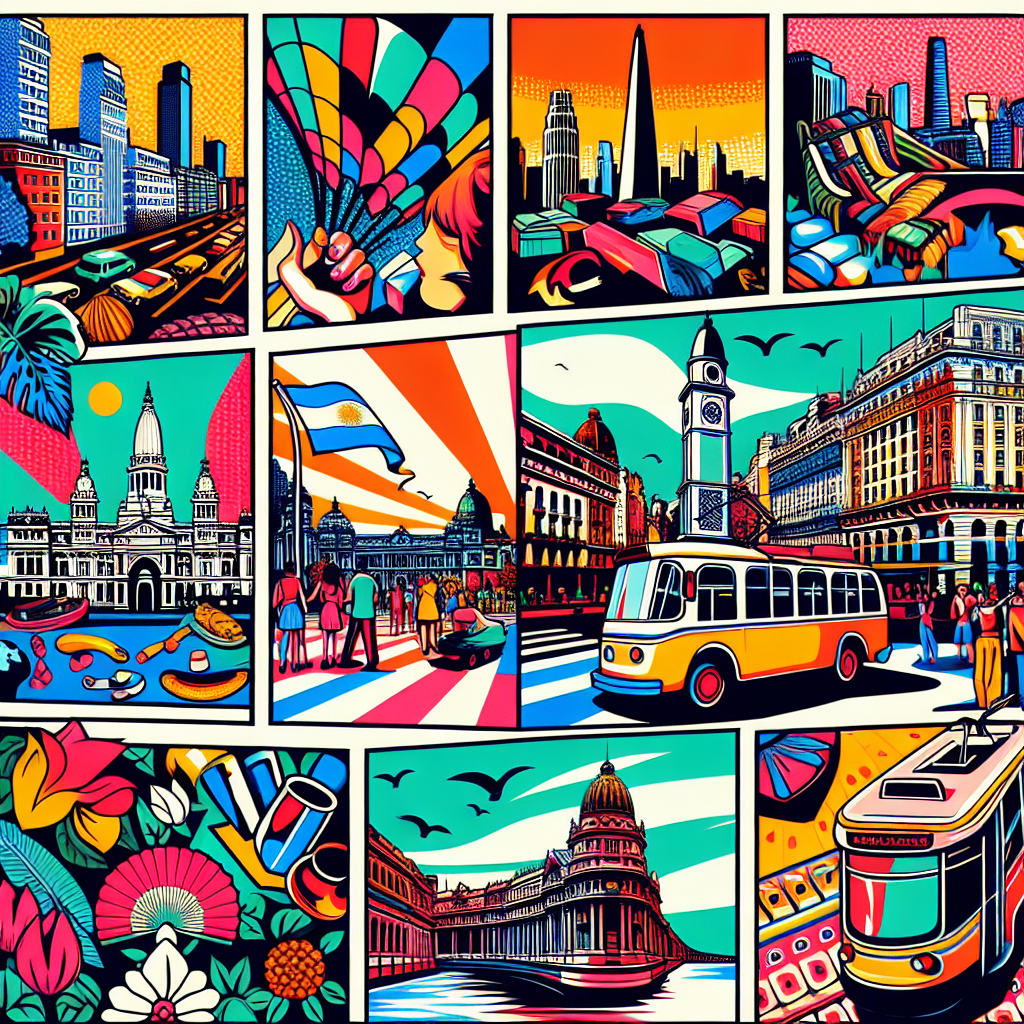

In [14]:
image = artist("Buenos Aires")
display(image)

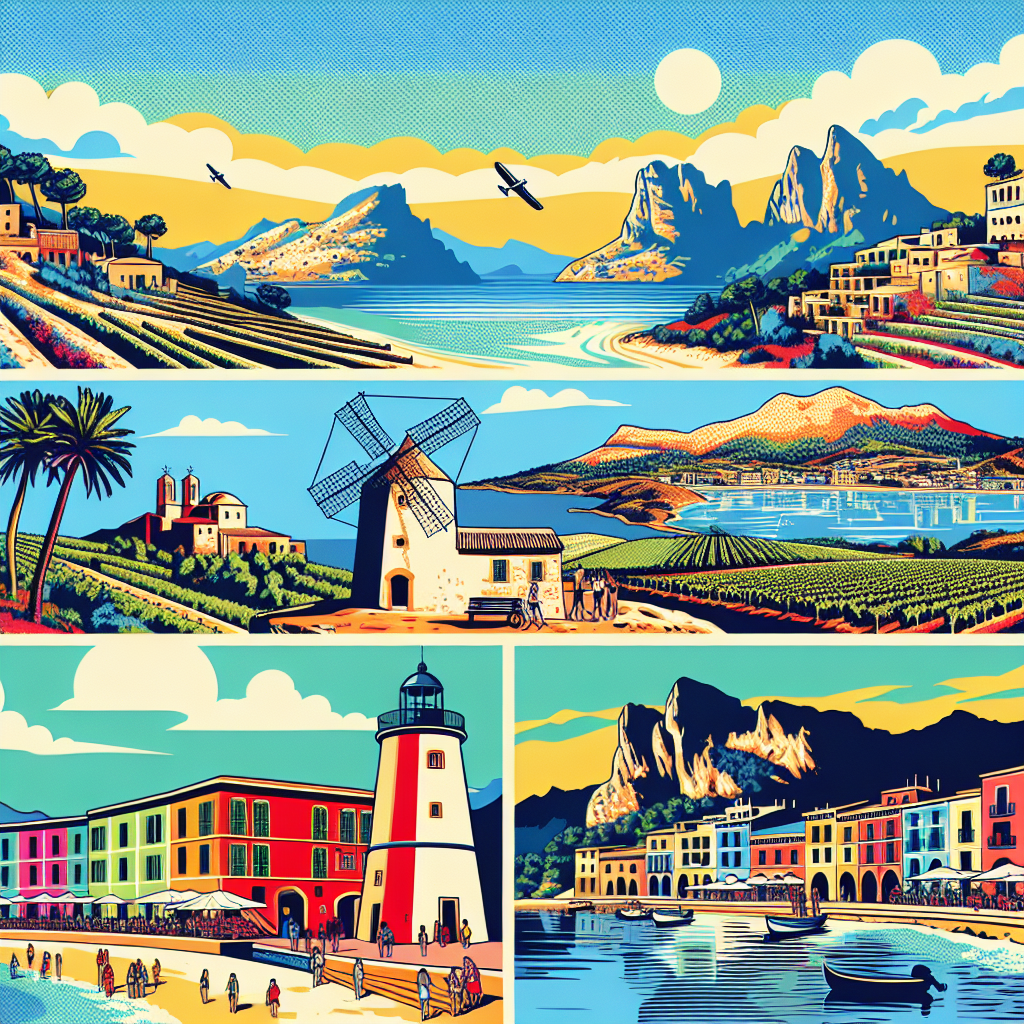

In [15]:
image = artist("Mallorca")
display(image)

## Audio

Hagamos una función para permitir hablar mediante el uso del modelo de voz de OpenAI para generar audio

### Solución de problemas de audio

Si tiene algún problema al ejecutar el código a continuación (como un error de FileNotFound o una advertencia de un paquete faltante), es posible que debas instalar FFmpeg, una utilidad de audio muy popular.

**Para usuarios de PC**

Las instrucciones detalladas están [aquí](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) e instrucciones resumidas:

1. Descargue FFmpeg desde el sitio web oficial: https://ffmpeg.org/download.html

2. Extraiga los archivos descargados a una ubicación en su computadora (por ejemplo, `C:\ffmpeg`)

3. Agregue la carpeta bin de FFmpeg a la RUTA de su sistema:
- Haga clic derecho en 'Esta PC' o 'Mi PC' y seleccione 'Propiedades'
- Haga clic en 'Configuración avanzada del sistema'
- Haga clic en 'Variables de entorno'
- En 'Variables del sistema', busque y edite 'Ruta'
- Agregue una nueva entrada con la ruta a su carpeta bin de FFmpeg (por ejemplo, `C:\ffmpeg\bin`)
- Reinicie su símbolo del sistema y, dentro de la carpeta bin de FFmpeg, Jupyter Lab en Kernel -> Reiniciar kernel para que se apliquen los cambios

4. Abra un nuevo símbolo del sistema y ejecútelo para asegurarse de que esté instalado correctamente
`ffmpeg -version`

**Para usuarios de Mac**

1. Instala homebrew si aún no lo tiene ejecutando esto en una ventana de terminal y siguiendo las instrucciones:
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Luego instala FFmpeg con `brew install ffmpeg`

3. Verifica la instalación con `ffmpeg -version` y si todo está bien, dentro de Jupyter Lab en Kernel -> Reiniciar kernel para aplicar los cambios

## Para comprobarlo, ahora tienes ffmpeg y puedes acceder a él aquí

Ejecuta la siguiente celda para ver si obtienes un número de versión. (Poner un signo de exclamación antes de algo en Jupyter Lab le indica que lo ejecute como un comando de terminal en lugar de código de Python).

Si esto no funciona, es posible que tengas que guardar y cerrar tu Jupyter Lab y volver a iniciarlo desde una nueva ventana de Terminal (Mac) o desde el símbolo del sistema de Anaconda (PC), recordando activar el entorno llms. Esto garantiza que puedas elegir ffmpeg.

In [16]:
!ffmpeg -version

zsh:1: command not found: ffmpeg


# Para usuarios de Mac

Esta versión debería funcionar bien para ti. También podría funcionar para usuarios de Windows, pero podrías obtener un error de permisos al escribir en un archivo temporal. Si es así, ¡consulta la siguiente sección!

Como siempre, si tienes problemas, ¡contacta conmigo! (También puedes comentar el audio talker() en el código posterior si no te interesa tanto la generación de audio)

In [17]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Puedes probar las voces disponibles que son (alloy, echo, fable, onyx, nova, y shimmer)
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [18]:
talker("Hola, aquí estamos!")

/Users/rodrigotristany/Desktop/Personal/llm-engineering-course/llm_engineering/llms/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

# Para usuarios de Windows

## Si recibe un error de permisos al escribir en un archivo temporal, este código debería funcionar.

¡Una colaboración entre los estudiantes Mark M. y Patrick H. y Claude resolvió este problema!

A continuación se muestran 3 variaciones; con suerte, una de ellas funcionará en su PC. Si no, ¡envíeme un mensaje!

## Variación 1 para PC

In [ ]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # El estudiante Dominic consideró que esto era necesario. También podrías intentar comentar para ver si no es necesario en tu PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Prueba también de reemplazar onyx por alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("Hola, aquí estamos!")

## Variación 2 para PC

In [ ]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # Set a custom directory for temporary files on Windows
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # You can also use 'TMP' if necessary
    
    # Create the folder if it doesn't exist
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

talker("Hola, aquí estamos!")

## Variación 3 para PC

### Probemos una librería de sonido completamente diferente

Primero ejecute la siguiente celda para instalar una nueva biblioteca y luego pruebe la celda que está debajo.

In [ ]:
!pip install simpleaudio

In [ ]:
from pydub import AudioSegment
from io import BytesIO
import tempfile
import os
import simpleaudio as sa

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Prueba también de reemplazar onyx por alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Create a temporary file in a folder where you have write permissions
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # Load and play audio using simpleaudio
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done()  # Wait for playback to finish

    # Clean up the temporary file afterward
    os.remove(temp_file_name)
    
talker("Hola, aquí estamos!")

## Usuarios de PC: si ninguna de esas 3 variantes funcionó.

Lamento que esto esté causando problemas, pero es el precio de usar tecnologías tan nuevas.

Reproducir audio desde su PC no es muy importante para este curso y puede concentrarse en la generación de imágenes y omitir el audio por ahora, o volver a hacerlo más tarde.

# Nuestro marco de trabajo para agentes

El término "IA Agentic" y la "agentización" es un término general que se refiere a una serie de técnicas, como:

1. Dividir un problema complejo en pasos más pequeños, con múltiples LLM que realizan tareas especializadas
2. La capacidad de los LLM de usar herramientas para darles capacidades adicionales
3. El "entorno del agente", que permite que los agentes colaboren
4. Un LLM puede actuar como planificador, dividiendo las tareas más grandes en tareas más pequeñas para los especialistas
5. El concepto de que un agente tenga autonomía/agencia, más allá de simplemente responder a una indicación, como la memoria

Mostramos aquí los pasos 1 y 2, y en menor medida los pasos 3 y 5. ¡En la semana 8 haremos todo!

In [19]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comenta o elimina la siguiente línea si prefiere omitir el audio por ahora.
    # talker(reply)
    
    return history, image

In [20]:
# Código Gradio más complejo, ya que no estamos usando la interfaz de chat predeterminada.
# Si pasamos inbrowser=True en la última línea, aparecerá inmediatamente una ventana Gradio.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chatea con nuestro Agente de IA:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


# Ejercicios y aplicaciones comerciales

Agrega más herramientas, tal vez para simular la reserva real de un vuelo. Un estudiante lo hizo y proporcionó su ejemplo en la carpeta de contribuciones de la comunidad.

A continuación, toma esto y aplícalo a tu negocio. Crea un asistente de IA multimodal con herramientas que puedan realizar una actividad para tu trabajo. ¿Un asistente de atención al cliente? ¿Un asistente de incorporación de nuevos empleados? ¡Tantas posibilidades! Además, consulta el ejercicio de fin de semana de la semana 2 en el cuaderno separado.